# Imports

In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB
from openmm.unit import kelvin, bar, litre, kilojoule_per_mole, mole, nanometer, angstrom, kilocalorie_per_mole, molal, molar,grams,milliliter,kilogram
from openmm.unit import Quantity, Unit
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import json
import os
from dataclasses import dataclass

/tmp/ipykernel_264430/912964738.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Constants

In [2]:
R = BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA # gas constant

In [3]:
@dataclass
class IonMolalInfo:
    '''For representing info about the systems' molecular composition'''
    molality : Quantity
    molarity : Quantity
    osm_coeff_exp : float

In [4]:
molal_infos = {
    1 : IonMolalInfo(
        molality=1.0*(mole / kilogram),
        molarity=0.976*(mole/litre),
        osm_coeff_exp=0.936,
    ),
    2 : IonMolalInfo(
        molality=2.0*(mole / kilogram),
        molarity=1.923*(mole/litre),
        osm_coeff_exp=0.984,
    ),
    3 : IonMolalInfo(
        molality=3.0*(mole / kilogram),
        molarity=2.823*(mole/litre),
        osm_coeff_exp=1.045,
    ),
}

# Utility Functions

In [5]:
def osm_experimental(exp_osm_coeff, molarity:Quantity=1*(mole/litre), vant_hoff:int=2, T=300*kelvin):
    osm_press_ideal=vant_hoff*molarity*R*T
    osm_press_ideal=osm_press_ideal.in_units_of(bar)
    osm_bar=exp_osm_coeff*osm_press_ideal
    op_error=(abs(osm_bar-osm_press_ideal)/osm_press_ideal)*100
    print(f'Ideal Osmotic Pressure: {osm_press_ideal} at concentraion {molarity}')
    print(f'Osmotic Pressure from experimental osmotic coefficient: {osm_bar}')
    return osm_bar


In [6]:
def load_results(calc_type):
    calc_type = calc_type.lower()
    # Get the directory of the current script
    script_dir = os.getcwd()

    if calc_type in ['fbp', 'fbps']:
        # Initialize lists for OP and OC values and errors
        fbp_op_values, fbp_op_errors, fbp_oc_values, fbp_oc_errors = [], [], [], []

        for idx, molality in enumerate(molalities, start=1):
            # Construct the relative path to the JSON file
            relative_path = os.path.join(script_dir,'..', fbp_dir, f'final_results_{idx}m.json')

            # Open and load the JSON file
            with open(relative_path, 'r') as file:
                results_json = json.load(file)

            # Append values and errors to respective lists
            fbp_op_values.append(results_json['mean_osmotic_pressure'])
            fbp_op_errors.append(results_json['uncertainty_osmotic_pressure'])
            fbp_oc_values.append(results_json['mean_osmotic_coefficient'])
            fbp_oc_errors.append(results_json['uncertainty_osmotic_coefficient'])

        # Create and return the dictionary
        return {
            "OP_Values": fbp_op_values,
            "OP_Errors": fbp_op_errors,
            "OC_Values": fbp_oc_values,
            "OC_Errors": fbp_oc_errors
        }

    elif calc_type in ['hp', 'hps']:
        # Initialize lists for OP and OC values and errors
        hp_op_values, hp_op_errors, hp_oc_values, hp_oc_errors = [], [], [], []

        # Construct the file path
        relative_path = os.path.join(script_dir,'..', hp_dir, 'final_results_35m.json')
        with open(relative_path, 'r') as file:
            results_json = json.load(file)

        # Loop through the data in the JSON lists
        for op, op_err, oc, oc_err in zip(
                results_json['osmotic_pressure'],
                results_json['osmotic_pressure_error'],
                results_json['osmotic_coefficient'],
                results_json['osmotic_coefficient_error']):
            
            # Append values and errors to respective lists
            hp_op_values.append(op)
            hp_op_errors.append(op_err)
            hp_oc_values.append(oc)
            hp_oc_errors.append(oc_err)

        # Create and return the dictionary
        return {
            "OP_Values": hp_op_values,
            "OP_Errors": hp_op_errors,
            "OC_Values": hp_oc_values,
            "OC_Errors": hp_oc_errors
        }


## Load results from json files

In [7]:
molalities = ['1m', '2m', '3m']
fbp_dir='FlatBottomPotentials_analysis'
hp_dir='HarmonicPotential_analysis'

In [8]:
fbp_results=load_results('fbps')
hp_results=load_results('hps')

## Experimental

In [9]:
# Molar concentrations corresponding to 1 molal, 2 molal, and 3 molal
concs=[molal_infos[i+1].molarity.in_units_of(mole/litre) for i,m in enumerate(molalities)]
exp_concs=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.2,1.4,1.5,1.7,1.9,2.4,2.8,3.3,3.7,4.1,4.5,4.9,5.3]*(mole/litre)

# yexpOC=[molal_infos[i+1].osm_coeff_exp for i in range(len(molalities))]
yexpOC=[0.932,0.925,0.922,0.920,0.921,0.923,0.926,0.929,0.932,0.936,0.943,0.951,0.962,0.972,0.983,1.013,1.045,1.080,1.116,1.153,1.192,1.231,1.271]

yexpOP=[]
for i,m in enumerate(exp_concs):
    op_res=osm_experimental(exp_osm_coeff=yexpOC[i], molarity=exp_concs[i])
    yexpOP.append(op_res.value_in_unit(op_res.unit))

Ideal Osmotic Pressure: 4.988677570891944 bar at concentraion 0.1 mol/L
Osmotic Pressure from experimental osmotic coefficient: 4.649447496071293 bar
Ideal Osmotic Pressure: 9.977355141783889 bar at concentraion 0.2 mol/L
Osmotic Pressure from experimental osmotic coefficient: 9.229053506150098 bar
Ideal Osmotic Pressure: 14.966032712675831 bar at concentraion 0.3 mol/L
Osmotic Pressure from experimental osmotic coefficient: 13.798682161087116 bar
Ideal Osmotic Pressure: 19.954710283567778 bar at concentraion 0.4 mol/L
Osmotic Pressure from experimental osmotic coefficient: 18.358333460882356 bar
Ideal Osmotic Pressure: 24.943387854459722 bar at concentraion 0.5 mol/L
Osmotic Pressure from experimental osmotic coefficient: 22.972860213957404 bar
Ideal Osmotic Pressure: 29.932065425351663 bar at concentraion 0.6 mol/L
Osmotic Pressure from experimental osmotic coefficient: 27.627296387599586 bar
Ideal Osmotic Pressure: 34.920742996243604 bar at concentraion 0.7 mol/L
Osmotic Pressure fr

## Plotting FBPs vs HP vs Experiments

In [10]:
# Formatting font size
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

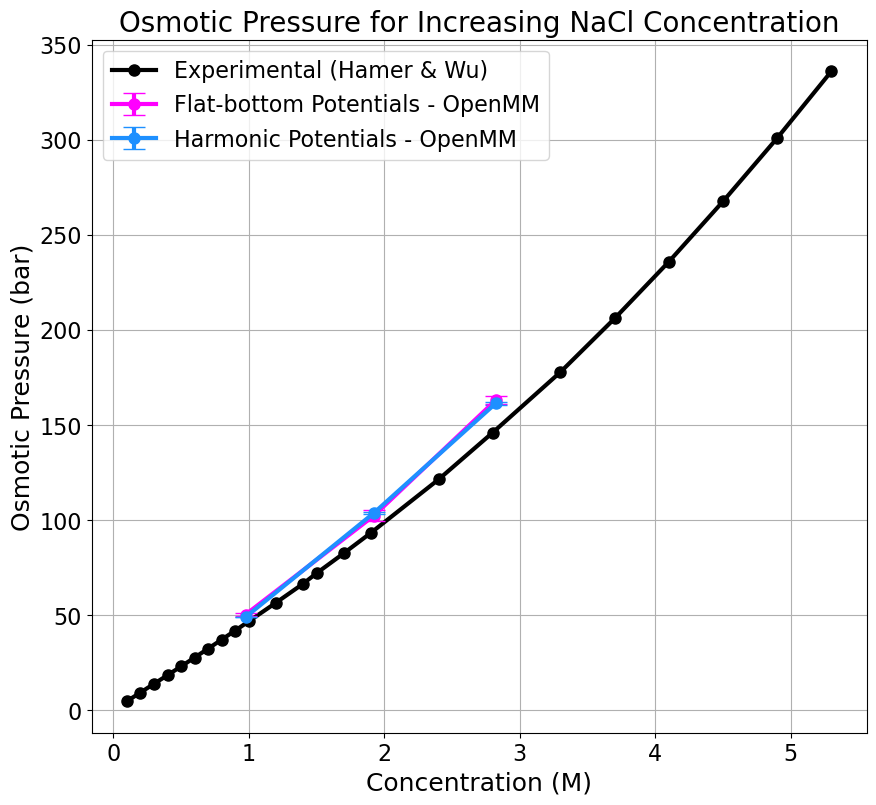

In [14]:
## Osmotic pressure plot
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10,9))
plt.plot([x._value for x in exp_concs],yexpOP, marker='o', linestyle='-',color='black', label='Experimental (Hamer & Wu)',linewidth=3,markersize=8)
plt.errorbar([x._value for x in concs], fbp_results['OP_Values'], yerr=fbp_results['OP_Errors'], fmt='o', linestyle='-',color='magenta', capsize=8, label='Flat-bottom Potentials - OpenMM',linewidth=3,markersize=8)
plt.errorbar([x._value for x in concs], hp_results['OP_Values'], yerr=hp_results['OP_Errors'], fmt='o', linestyle='-',color='dodgerblue', capsize=8, label='Harmonic Potentials - OpenMM',linewidth=3,markersize=8)
plt.xlabel("Concentration (M)", fontsize=MEDIUM_SIZE)
plt.ylabel("Osmotic Pressure (bar)", fontsize=MEDIUM_SIZE)
plt.title('Osmotic Pressure for Increasing NaCl Concentration', fontsize=BIGGER_SIZE)
plt.legend()
plt.grid()
plt.savefig('fbps_vs_hp_OPs.png')
plt.show()

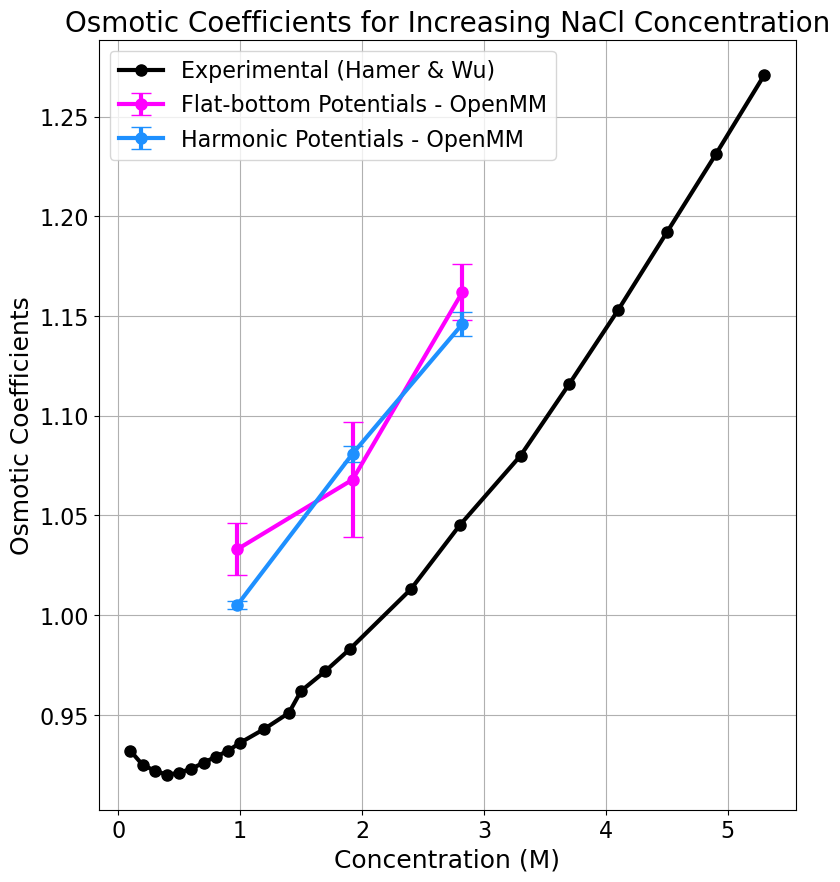

In [15]:
# Osmotic coefficient plot
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(9.0,10.0))
plt.plot([x._value for x in exp_concs],yexpOC, marker='o', linestyle='-',color='k', label='Experimental (Hamer & Wu)', lw=3, markersize=8)
plt.errorbar([x._value for x in concs], fbp_results['OC_Values'], yerr=fbp_results['OC_Errors'], fmt='o', linestyle='-',color='magenta', capsize=7, label='Flat-bottom Potentials - OpenMM', lw=3, markersize=8)
plt.errorbar([x._value for x in concs], hp_results['OC_Values'], yerr=hp_results['OC_Errors'], fmt='o', linestyle='-',color='dodgerblue', capsize=7, label='Harmonic Potentials - OpenMM', lw=3, markersize=8)
plt.xlabel("Concentration (M)",fontsize=MEDIUM_SIZE)
plt.ylabel("Osmotic Coefficients",fontsize=MEDIUM_SIZE)
# plt.xlim(0.5,3.5)
# plt.ylim(0.92,1.22)
plt.title('Osmotic Coefficients for Increasing NaCl Concentration', fontsize=BIGGER_SIZE)
plt.legend(prop={'size': 16}, loc='upper left')
plt.grid()
plt.savefig('fbps_vs_hp_OCs.png')
plt.show()